In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm # progress indicator
import time
#import matplotlib
#matplotlib.use("nbagg")   #подключить эти пакеты для анимации

t1 = time.perf_counter()
#def main():
S = 5000 # размерность матрицы    
dx = 0.01 # шаг по сетке
L = dx*(S+2)# длина ящика для нулевых краевых условий
x = np.linspace(-L/2+dx, L/2-dx, S) # список x_i от -L/2+dx до L/2-dx
k = 1/(2*dx**2) # типа волновой вектор для матрицы гам-на
lq = 3
EJ = 1
T = 1 # весь интервал времени
dt = 0.01 # шаг для у-я Паули
Dt = 0.1 # шаг для изменения возмущения
t = np.linspace(dt, T, int(T/dt)) # список всез точек по времени
phix_start = 0 # нач-е значение внешнего потока
phix_end = np.pi/10 # конечное
phx = np.linspace(phix_start, phix_end, int(T/Dt)) # список значений внешнего потока
phix = phx[0] # поток в нулевой момент времени
gamma = 1 # типа коэффициент рения
const = gamma*2*np.pi # константа ур-я Паули

U = lambda phi: (phix - phi)**2/(2*lq) + 1 - np.cos(phi)
v = U(x)
U_comp = min(v[0], v[S-1]) # максимально допустимое зн-е энергии
##############################################
# матрица Гамильтониана
##############################################
h = np.zeros((S,S))
for i in range(S-1):
    h[i+1][i] = -1*k
    h[i][i+1] = -1*k
for i in range(S):
    h[i][i] = 2*k + v[i]
eigvals, eigvecs = linalg.eigh(h)
border = 5     # 0.05*U_comp
eigvals_new = list(filter(lambda x: x < U_comp - border, eigvals))
N_trunc = len(eigvals_new) # уровень отсечения ФИКСИРОВАННЫЙ

#########################################################
# Заполнение матриц W
#########################################################

def squred_abs(n, m, x): # квадрат модуля матричного элемента x
    n_ket = eigvecs[:,n]
    m_bra = eigvecs[:,m] 
    integ = sum(n_ket*x*m_bra)
    return np.abs(integ)**2

W = np.zeros([N_trunc, N_trunc])
#for i in tqdm(range(N_trunc)):
for i in range(N_trunc):
    for j in range(N_trunc):
        if i<j: 
            W[i][j] = const*squred_abs(j, i, x)

def pauli_vec_func(rho, W):  # принимает на вход распределение и W, на выходе  
    res = []
    for m in range(N_trunc):
        plus = 0
        minus = 0
        for n in range(N_trunc): 
            plus += rho[n]*W[m][n]
            minus += W[n][m] 
        minus = minus*rho[m]
        res.append(plus - minus)
    return np.array(res)
print(time.perf_counter() - t1)

60.36458919999998


Пусть мы иеем {$\vec{b_1}$,..., $\vec{b_n}$} - новый базис рамерности n. Он выражается через старый базис {$\vec{a_1}$,..., $\vec{a_n}$} как:

\begin{equation*}
 \begin{cases}
   \alpha_{11}\vec{a_1}+\alpha_{21}\vec{a_2}+..+\alpha_{n1}\vec{a_n}=\vec{b_1}
   \\
   ..........
   \\
   \alpha_{1n}\vec{a_1}+\alpha_{2n}\vec{a_2}+..+\alpha_{nn}\vec{a_n}=\vec{b_n},
 \end{cases}
\end{equation*}

где Alpha - матрица перехода от старого базиса к новому.
В матричном виде система уравнений запишется как:

$(\vec{a_1}, \vec{a_2},...,\vec{a_n}) Alpha = (\vec{b_1}, \vec{b_2},...,\vec{b_n})$. Тогда поиск матрицы перехода методом np.linalg.solve(a, b) осуществляется записью Alpha = np.linalg.solve(eigvecs, eigvecs_new).
Вектор плотности в новом базисе: $rho_{new} = Alpha^{-1} rho_{old}$

In [2]:
# основной блок по времени
n_init = 0
n_tt = int(Dt/dt)
rho_init = np.zeros([N_trunc])
rho_init[n_init] = 1
rho_curr = rho_init # в у-е Паули подставляется начальное распределение
s = 0 # счетчик по точкам phix

for it in tqdm(range(1,len(t))):
    if it%n_tt != 0: 
        k1 = pauli_vec_func(rho_curr, W)
        k2 = pauli_vec_func(rho_curr + (dt/2)*k1, W)
        k3 = pauli_vec_func(rho_curr + (dt/2)*k2, W)
        k4 = pauli_vec_func(rho_curr + dt*k3, W)
        rho_curr = rho_curr + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    else:
        s += 1
        phix = phx[s]
        #x = np.linspace(-L/2+dx+phix, L/2-dx+phix, S)
        U = lambda phi: (phix - phi)**2/(2*lq) + 1 - np.cos(phi)
        v = U(x)
        U_comp = min(v[0], v[S-1]) # максимально допустимое зн-е энергии
        h = np.zeros((S,S))
        for i in range(S-1):
            h[i+1][i] = -1*k
            h[i][i+1] = -1*k
        for i in range(S):
            h[i][i] = 2*k + v[i]
        eigvals_new, eigvecs_new = linalg.eigh(h)
        C = linalg.solve(eigvecs, eigvecs_new)[:N_trunc, :N_trunc] # РАЗМЕРНОСТЬ!!!!!!!!!! ну и вообще сомнительно
        rho_curr = np.dot(linalg.inv(C),rho_curr)
        eigvals, eigvecs = eigvals_new, eigvecs_new
        rho_coor = np.zeros([S, S])
        for i in range(N_trunc): # для выбранных уровней
            rho_coor = rho_coor + np.array([eigvecs[:,i]]).T*eigvecs[:,i]*rho_curr[i]
        W = np.zeros([N_trunc, N_trunc])
        for i in range(N_trunc):
            for j in range(N_trunc):
                if i<j: 
                    W[i][j] = const*squred_abs(j, i, x)                                                                
                                                                                   
        plt.imshow(rho_coor)
        plt.title('Time moment {}'.format(it*dt))
        plt.colorbar()
        plt.show()
                                                                                   
                                                                                   

        
         
        

  9%|███████▌                                                                           | 9/99 [00:02<00:25,  3.48it/s]

KeyboardInterrupt: 

In [4]:
# кусочек для проверки
n_init = 0
n_tt = int(Dt/dt)
rho_init = np.zeros([N_trunc])
rho_init[n_init] = 1
rho_curr = rho_init # начальное распределение соот-т нулевому состоянию
phix = np.pi/3 # новое значенеи потока
#x = np.linspace(-L/2+dx+phix, L/2-dx+phix, S)
U = lambda phi: (phix - phi)**2/(2*lq) + 1 - np.cos(phi)
v = U(x)
U_comp = min(v[0], v[S-1]) # максимально допустимое зн-е энергии
h = np.zeros((S,S))
for i in range(S-1):
    h[i+1][i] = -1*k
    h[i][i+1] = -1*k
for i in range(S):
    h[i][i] = 2*k + v[i]
eigvals_new, eigvecs_new = linalg.eigh(h) # новые векторы
C = linalg.solve(eigvecs, eigvecs_new)[:N_trunc, :N_trunc] # матрица перехода
rho_curr = np.dot(linalg.inv(C),rho_curr) # вектор плотности в новом базисе
eigvals, eigvecs = eigvals_new, eigvecs_new
# кусочек построения координатной плотности
rho_coor = np.zeros([S, S])
for i in range(N_trunc): # для выбранных уровней
    rho_coor = rho_coor + np.array([eigvecs[:,i]]).T*eigvecs[:,i]*rho_curr[i]
W = np.zeros([N_trunc, N_trunc]) # перерасчет Wnm для нового состояния
for i in range(N_trunc):
    for j in range(N_trunc):
        if i<j: 
            W[i][j] = const*squred_abs(j, i, x)                                                                

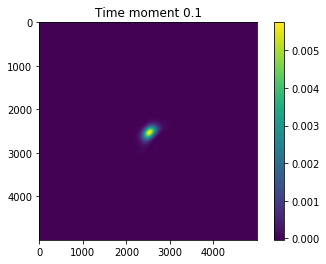

In [5]:
# построение коорднатного распеределения (проблема: возможны отрицательные значения)
plt.imshow(rho_coor)
plt.title('Time moment {}'.format(it*dt))
plt.colorbar()
plt.show()

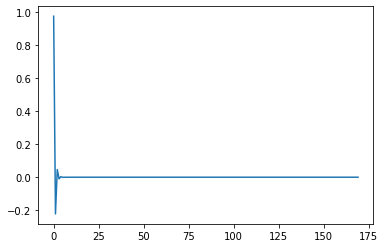

In [6]:
# построение вектора плотности в новом базисе (проблема: принимает отрицательные значения)
plt.plot(rho_curr)
plt.show()

In [7]:
# не смотря на "отрицательность", норма сохраняется. ну и что дальше?
np.sqrt(np.sum(rho_curr**2))

0.999999999999999